In [1]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

import torch
from engine import DatasetProvider, Trainer, DatasetName
from models.LeNet import LeNet
from utils.get_gpu import get_gpu
import matplotlib.pyplot as plt

In [2]:
dataset = DatasetProvider(dataset_name=DatasetName.MNIST, batch_size=64, padding=2)

dataset

In [3]:
model = LeNet(out_features=10)

model

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ChannelsSelectedConv2d(
      (layers): ModuleList(
        (0-5): 6 x Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
        (6-14): 9 x Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
        (15): Conv2d(6, 1, kernel_size=(5, 5), stride=(1, 1))
      )
    )
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): Tanh()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Tanh()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [4]:
model.net[3].state_dict()

OrderedDict([('layers.0.weight',
              tensor([[[[ 0.0479, -0.0545,  0.0485,  0.0270, -0.1079],
                        [-0.0847, -0.0415,  0.0675,  0.0649,  0.0718],
                        [ 0.1104,  0.1045,  0.0694, -0.0942, -0.0456],
                        [-0.1047,  0.0189,  0.1069,  0.0768,  0.1015],
                        [-0.0424,  0.0351, -0.0931, -0.0656, -0.0911]],
              
                       [[ 0.0124, -0.0665,  0.0241, -0.0391,  0.1132],
                        [-0.0377,  0.0481,  0.0862, -0.1085,  0.0769],
                        [ 0.0920,  0.0491,  0.1003, -0.0625,  0.0802],
                        [-0.0044,  0.0835,  0.0202,  0.0789,  0.0634],
                        [-0.0813,  0.0147, -0.0716, -0.1095, -0.0891]],
              
                       [[ 0.0399, -0.0089,  0.0782,  0.0859,  0.0378],
                        [-0.0682, -0.0801,  0.0570, -0.0397,  0.0755],
                        [ 0.0521,  0.1014, -0.0869, -0.0067, -0.0194],
            

In [5]:
trainer = Trainer(
    model=model,
    dataset=dataset,
    loss_name="cross_entropy",
    optimizer_name="adam",
    lr=0.01,
    device=get_gpu()
)

╭─ Experiment Config ─╮
│ Starting Training   │
│ Model: LeNet        │
│ Dataset: mnist      │
│ Device: mps         │
╰─────────────────────╯

In [6]:
images, labels = next(iter(dataset.trainloader))

In [7]:
images[0].shape

torch.Size([1, 32, 32])

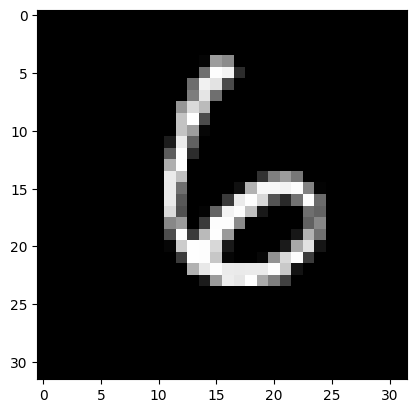

In [8]:
plt.imshow(images[0].reshape(32, 32), cmap=plt.cm.gray)

In [9]:
dataset = DatasetProvider(dataset_name=DatasetName.MNIST, batch_size=128, padding=2)
model = LeNet(out_features=10)

trainer = Trainer(
    model=model,
    dataset=dataset,
    loss_name="cross_entropy",
    optimizer_name="sgd",
    lr=0.01,
    device=get_gpu()
)

trainer.train(max_epochs=35)

╭─ Experiment Config ─╮
│ Starting Training   │
│ Model: LeNet        │
│ Dataset: mnist      │
│ Device: mps         │
╰─────────────────────╯

Output()

✔ Training Complete!

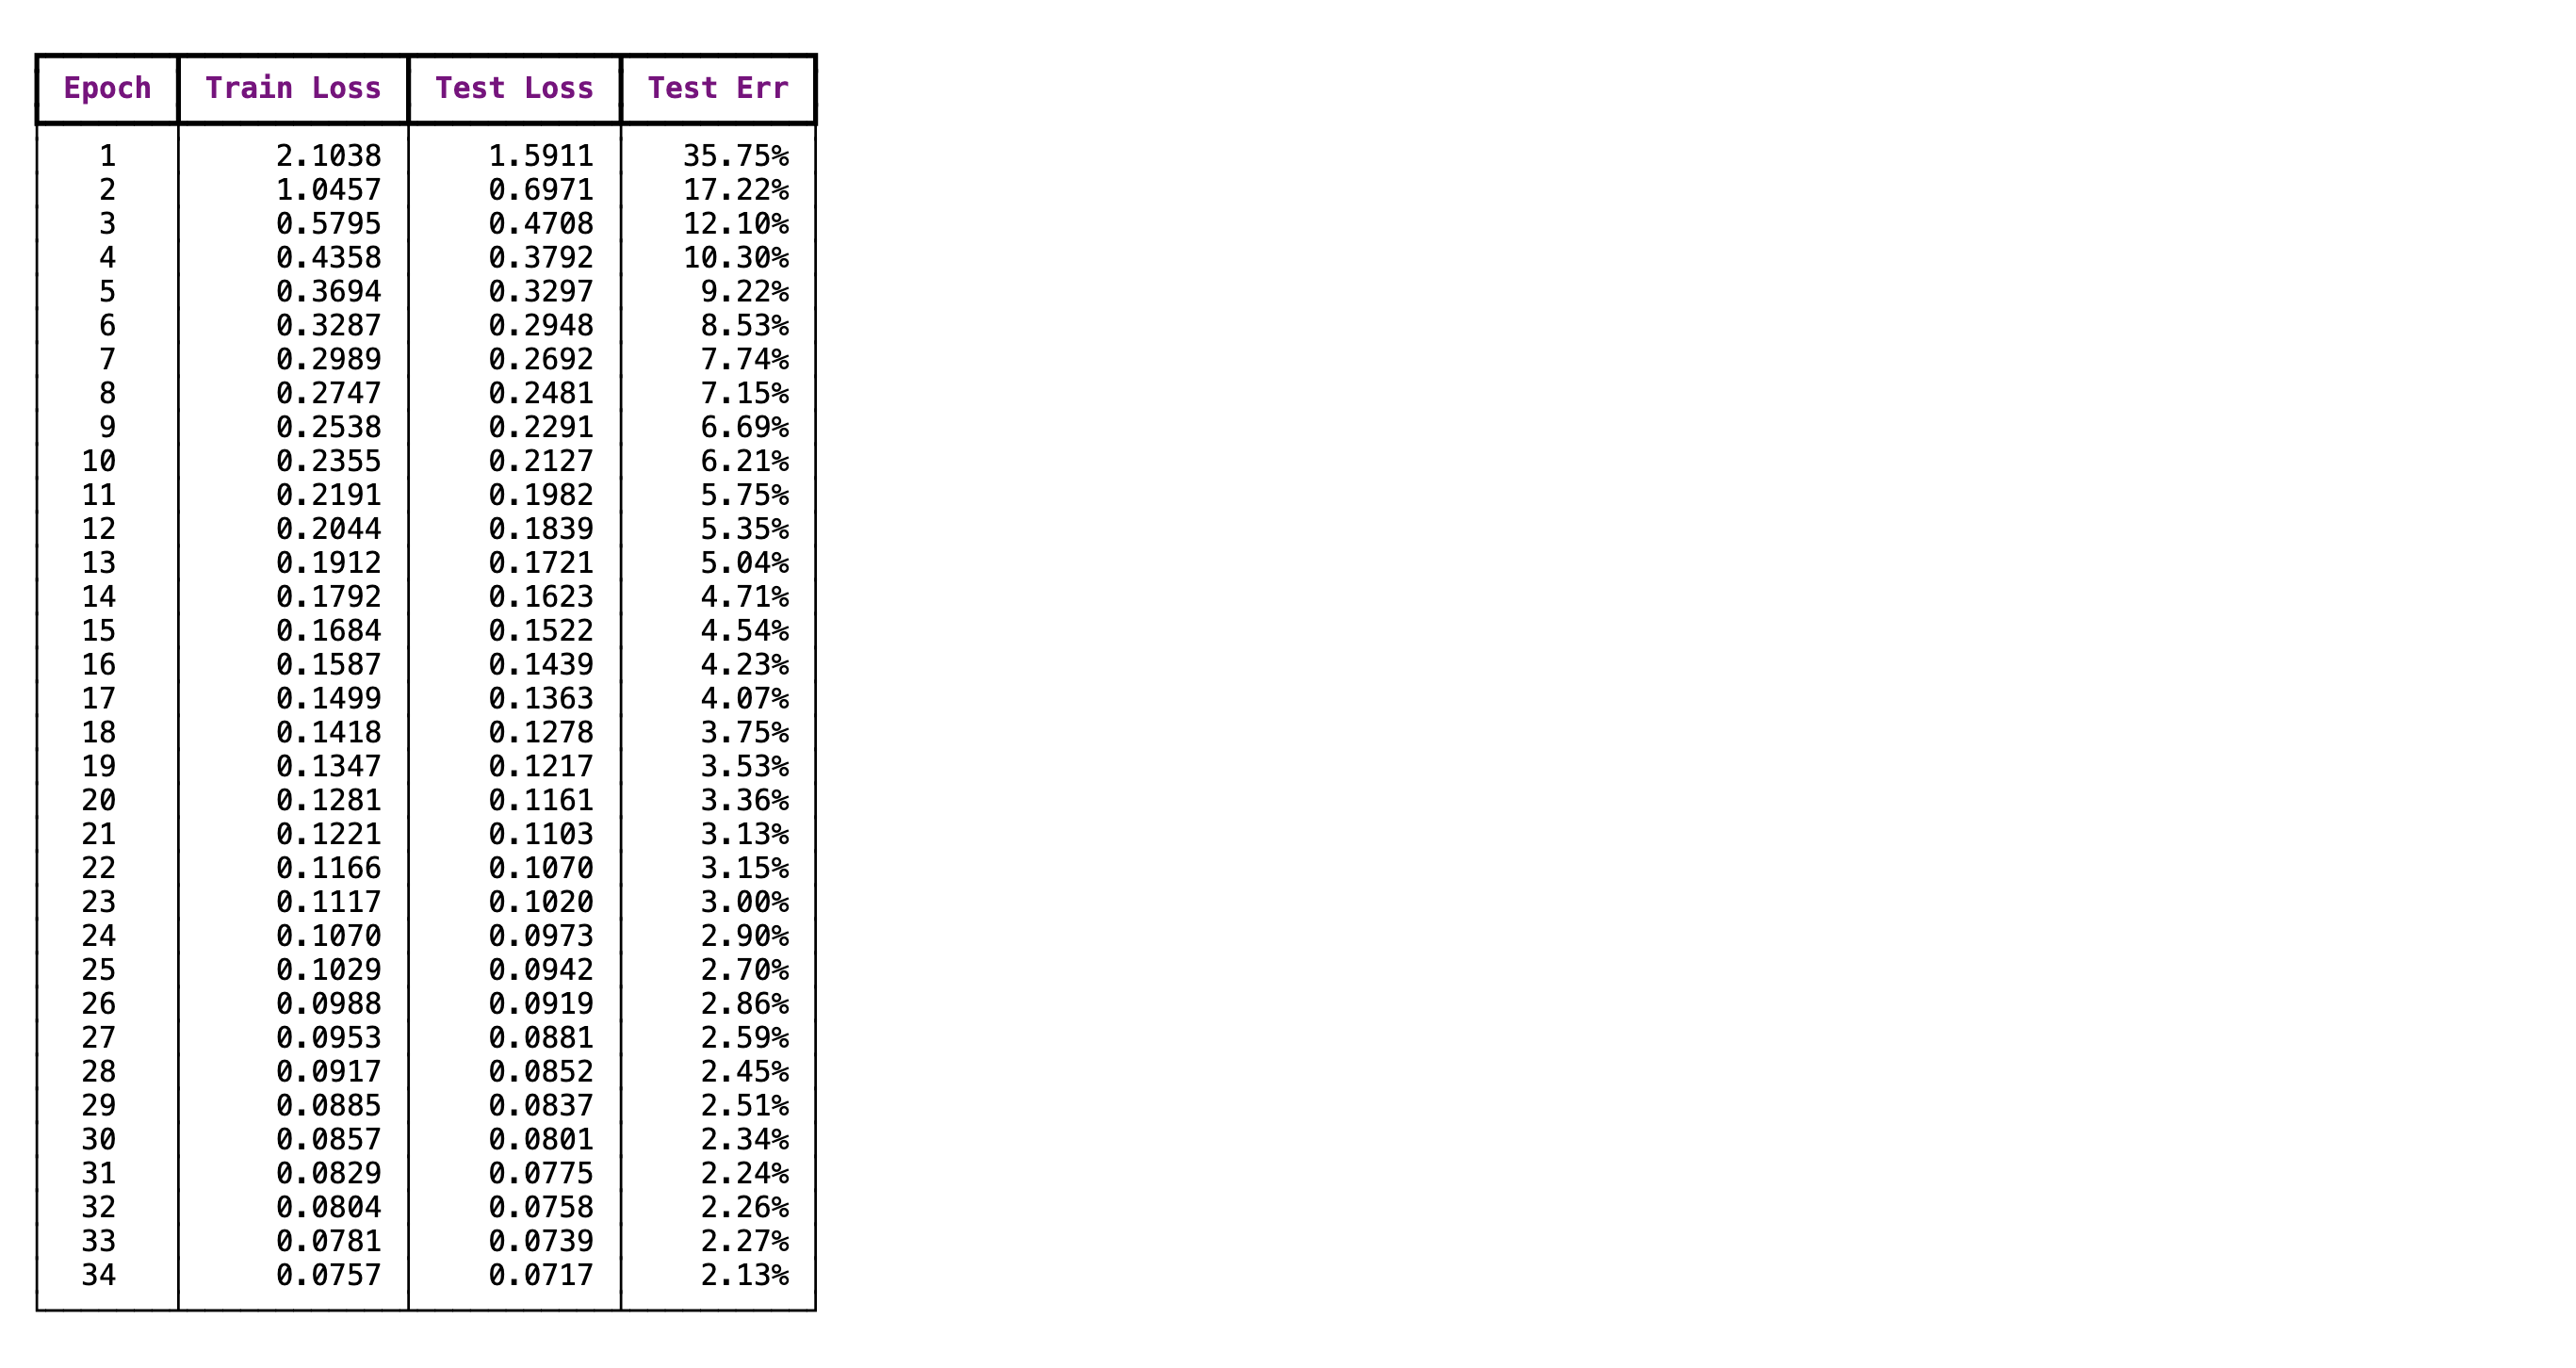

In [10]:
torch.save(model.state_dict(), "lenet_v1.pth")

In [11]:
train_losses, val_losses, val_err = trainer.history.values()

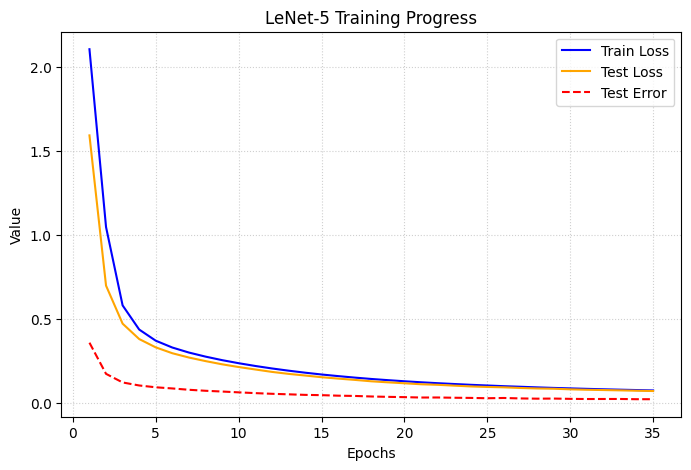

In [12]:
epochs = range(1, len(train_losses) + 1)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(epochs, train_losses, label='Train Loss', color='blue')
ax.plot(epochs, val_losses, label='Test Loss', color='orange')
ax.plot(epochs, val_err, label='Test Error', color='red', linestyle='--')

ax.set_title('LeNet-5 Training Progress')
ax.set_xlabel('Epochs')
ax.set_ylabel('Value')
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend()

plt.show()

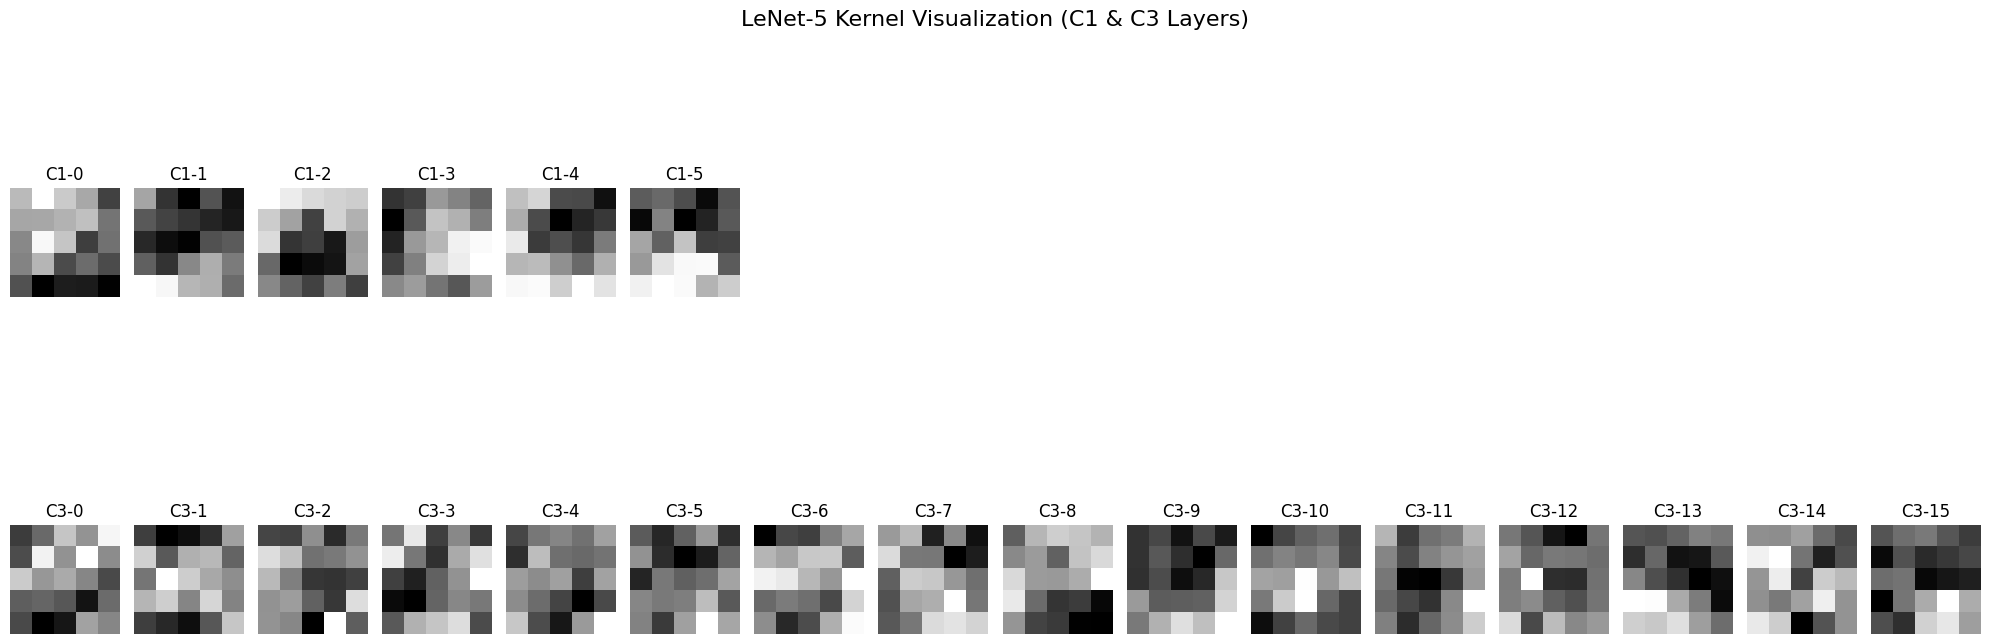

In [39]:
c1_weights = model.net[0].weight.data.cpu()
c3_weights_list = [layer.weight.data.cpu() for layer in model.net[3].layers]

fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, 16) 

for i in range(6):
    ax = fig.add_subplot(gs[0, i])
    w_img = c1_weights[i].squeeze().numpy()
    ax.imshow(w_img, cmap='gray')
    ax.set_title(f"C1-{i}")
    ax.axis('off')

for i, weight in enumerate(c3_weights_list):
    ax = fig.add_subplot(gs[1, i])
    w_img = weight.squeeze().mean(dim=0).numpy()
    
    ax.imshow(w_img, cmap='gray')
    ax.set_title(f"C3-{i}")
    ax.axis('off')

plt.suptitle("LeNet-5 Kernel Visualization (C1 & C3 Layers)", fontsize=16)
plt.tight_layout()
plt.show()

In [3]:
class LeNetVisualization(LeNet):
    def __init__(self, out_features=10):
        super().__init__(out_features)
    
    def forward(self, X):
        feature_maps = [X]
        current_input = X
        
        for layer in self.net:
            current_input = layer(current_input)
            feature_maps.append(current_input)
        
        return current_input, feature_maps

In [4]:
model = LeNetVisualization()
model.load_state_dict(torch.load("lenet_v1.pth"))

<All keys matched successfully>

In [5]:
images, labels = next(iter(dataset.trainloader))

In [17]:
image1 = images[21]
image2 = images[4]

In [18]:
_, feature_maps1 = model(image1.unsqueeze(dim=0))
_, feature_maps2 = model(image2.unsqueeze(dim=0))

In [19]:
len(feature_maps1)

13

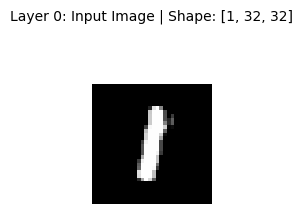

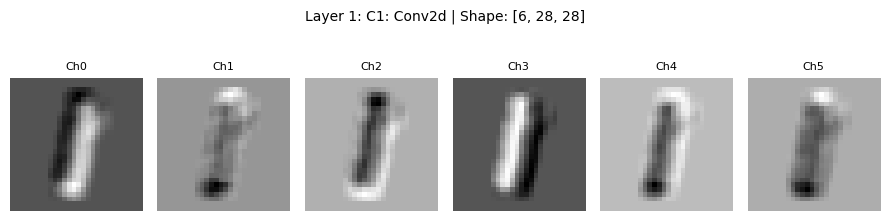

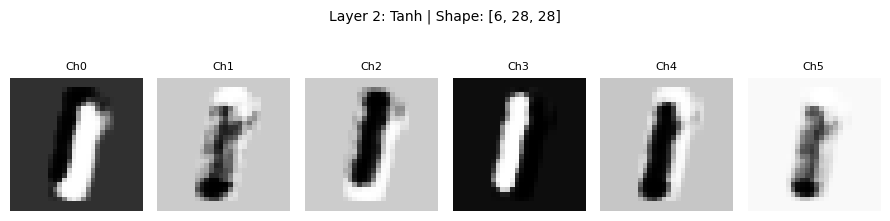

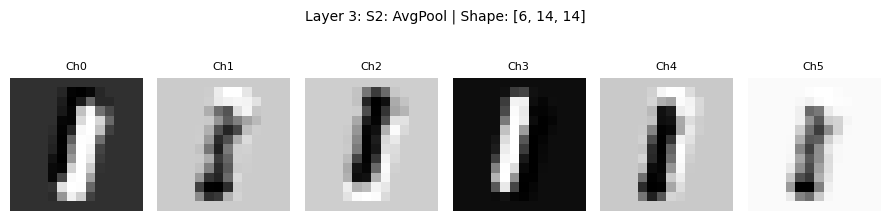

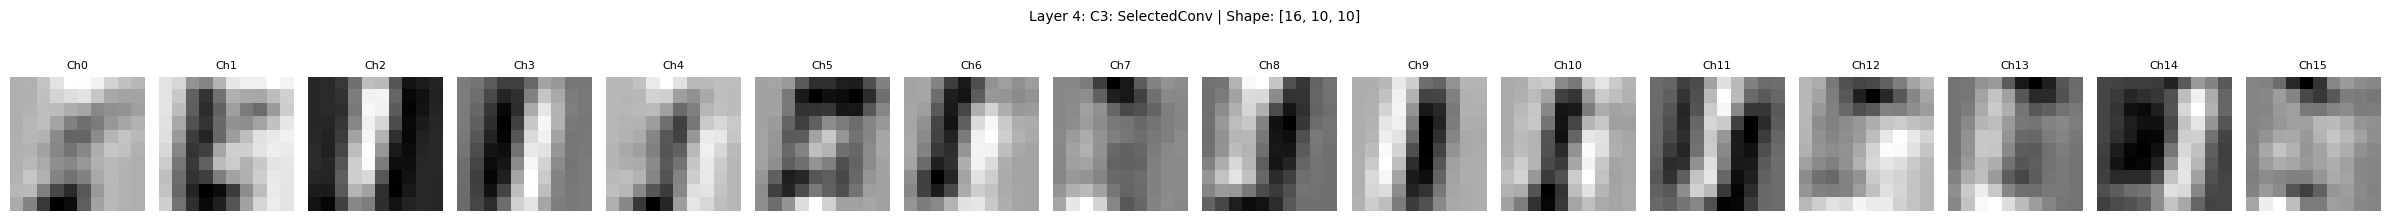

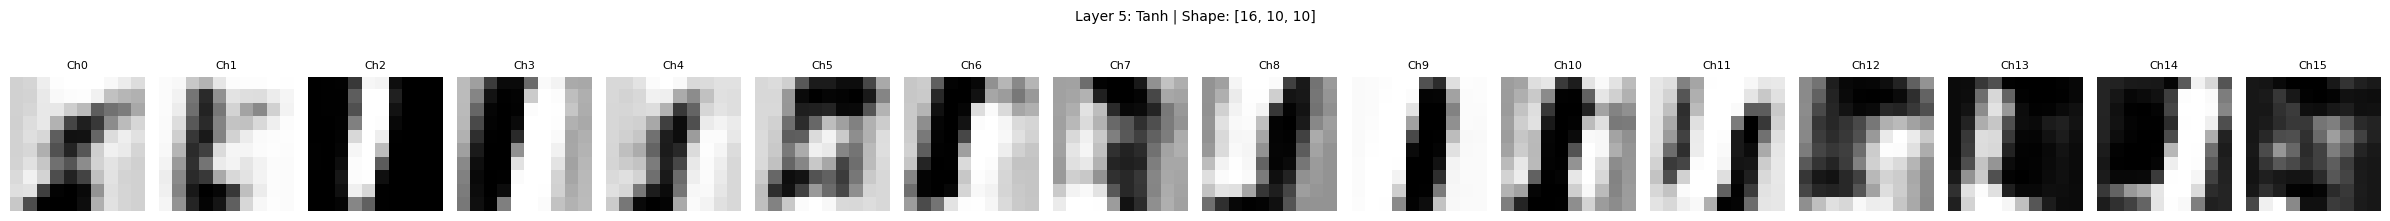

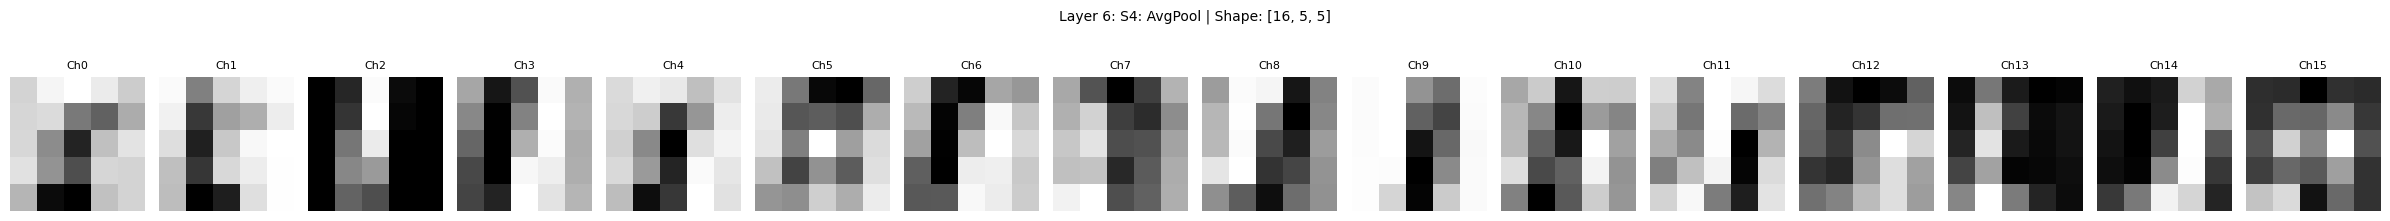

In [20]:
layer_names = [
    "Input Image", "C1: Conv2d", "Tanh", "S2: AvgPool", 
    "C3: SelectedConv", "Tanh", "S4: AvgPool", 
    "Flatten", "FC: 120", "Tanh", "FC: 84", "Tanh", "FC: 10"
]

n_visualize = 7 

for i in range(n_visualize):
    f_map = feature_maps1[i].detach().cpu()
    
    n_channels = f_map.shape[1]
    spatial_dim = f_map.shape[2:] 
    
    fig, axes = plt.subplots(1, n_channels, figsize=(n_channels * 1.5, 2))
    fig.suptitle(f"Layer {i}: {layer_names[i]} | Shape: {list(f_map.shape[1:])}", fontsize=10, y=1.1)
    
    if n_channels == 1:
        axes = [axes]
    
    for j in range(n_channels):
        axes[j].imshow(f_map[0, j], cmap='gray')
        axes[j].axis('off')
        
        if n_channels > 1:
            axes[j].set_title(f"Ch{j}", fontsize=8)

    plt.tight_layout()
    plt.show()

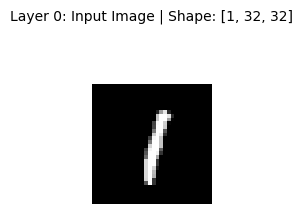

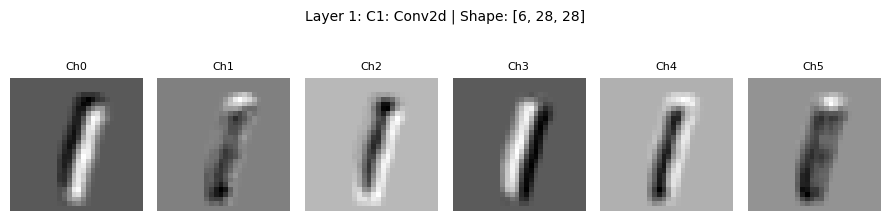

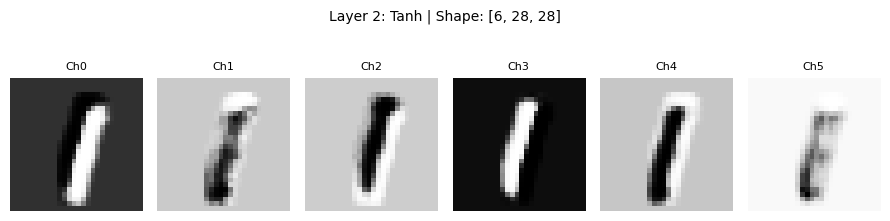

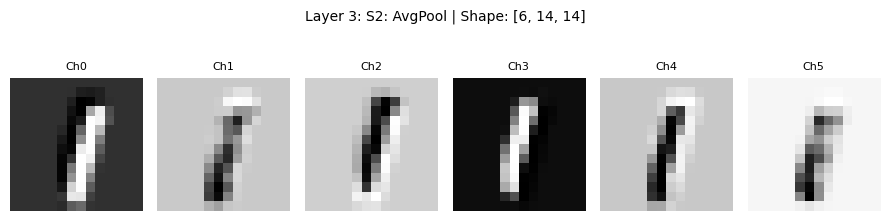

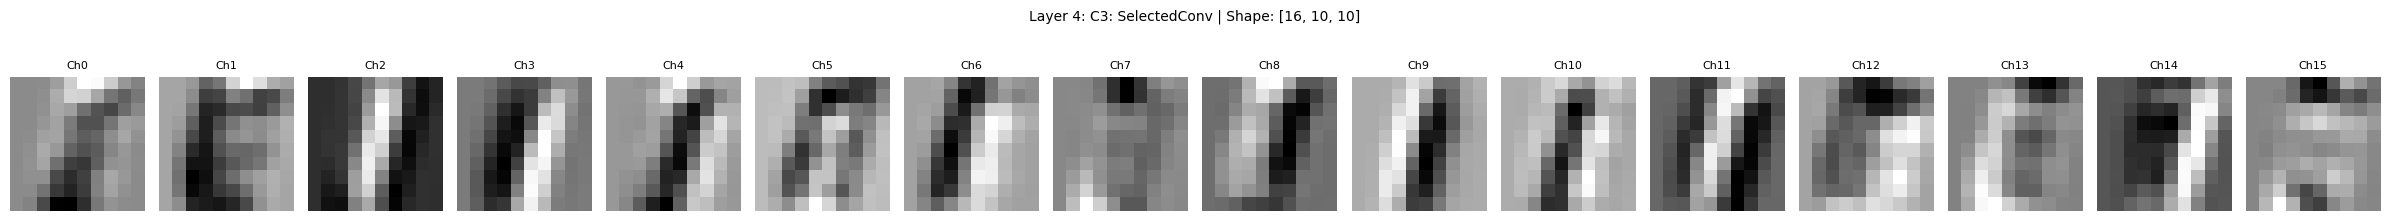

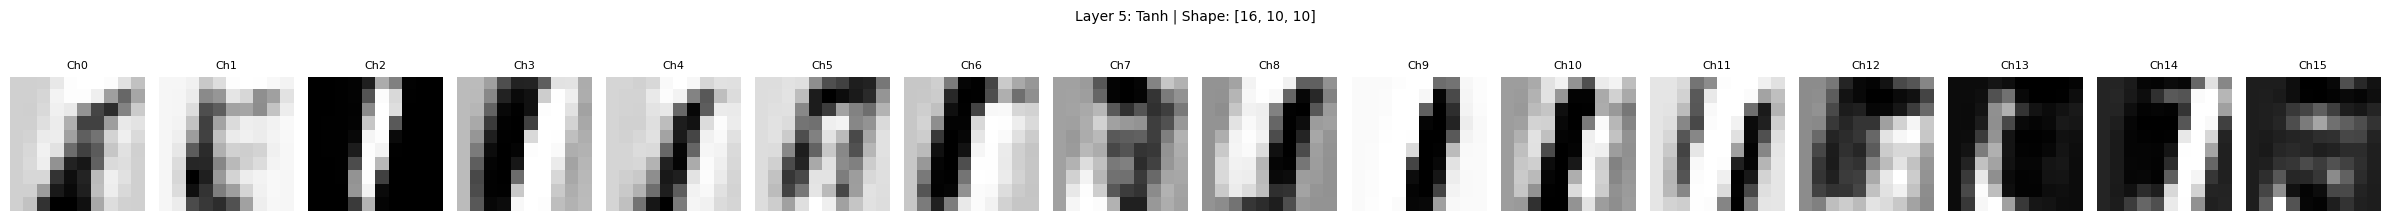

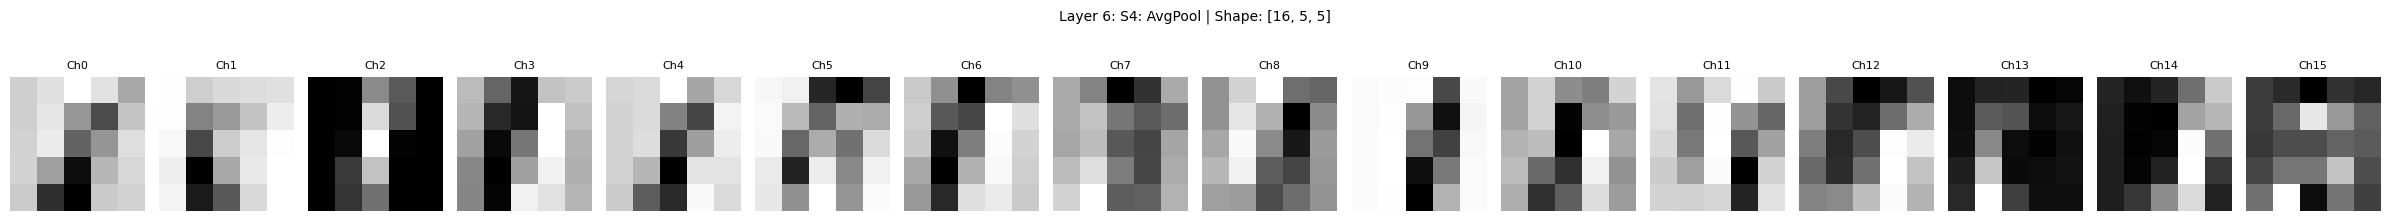

In [21]:
layer_names = [
    "Input Image", "C1: Conv2d", "Tanh", "S2: AvgPool", 
    "C3: SelectedConv", "Tanh", "S4: AvgPool", 
    "Flatten", "FC: 120", "Tanh", "FC: 84", "Tanh", "FC: 10"
]

n_visualize = 7 

for i in range(n_visualize):
    f_map = feature_maps2[i].detach().cpu()
    
    n_channels = f_map.shape[1]
    spatial_dim = f_map.shape[2:] 
    
    fig, axes = plt.subplots(1, n_channels, figsize=(n_channels * 1.5, 2))
    fig.suptitle(f"Layer {i}: {layer_names[i]} | Shape: {list(f_map.shape[1:])}", fontsize=10, y=1.1)
    
    if n_channels == 1:
        axes = [axes]
    
    for j in range(n_channels):
        axes[j].imshow(f_map[0, j], cmap='gray')
        axes[j].axis('off')
        
        if n_channels > 1:
            axes[j].set_title(f"Ch{j}", fontsize=8)

    plt.tight_layout()
    plt.show()